Лабораторная работа № 5 по Нейроинформатике

Сети с обратными связями

Выполнила: Тимофеева Наталья М8О-408Б-19

Вариант № 16

Сеть Элмана

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [28]:
class ElmanLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w1 = nn.Parameter(torch.randn(in_features, out_features))
        self.w2 = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))
    def forward(self, x):
        out = torch.matmul(x, self.w1)
        if hasattr(self, 'prev'):
            d = torch.matmul(x, self.w2)
            out = torch.add(out, self.bias)
            out = torch.add(out, d)
        else:
            out = torch.add(out, self.bias)
        out = torch.tanh(out)
        self.prev = out.clone().detach()
        return out
    def clean_memory(self):
        if hasattr(self, 'prev'):
            delattr(self, 'prev')

Задаём функцию

In [29]:
def make_signal(r1, r2, r3):
    k1 = np.arange(0, 1 + 0.025, 0.025)
    k2 = np.arange(0.48, 2.71 + 0.025, 0.025)
    p1 = np.sin(4 * np.pi * k1)
    p2 = np.sin(np.sin(k2) * k2 ** 2) - 0.1
    t1 = -1 * np.ones(len(p1))
    t2 = 1 * np.ones(len(p2))
    signal = np.concatenate((np.tile(p1, r1), p2, np.tile(p1, r2), p2, np.tile(p1, r3), p2))
    label = np.concatenate((np.tile(t1, r1), t2, np.tile(t1, r2), t2, np.tile(t1, r3), t2))
    return signal, label

In [30]:
def windows(signal, labels, window_size = 2):
    signal_windows = [np.array(signal[i : i + window_size], dtype=np.float32) for i in range(0, len(signal) - window_size)]
    labels_windows = [np.array(labels[i : i + window_size], dtype=np.float32) for i in range(0, len(signal) - window_size)]
    split = [(signal_value, labels_value) for signal_value, labels_value in zip(signal_windows, labels_windows)]
    return split

In [31]:
epochs = 100
size_of_window = 15

In [32]:
signal, labels = make_signal(r1 = 7, r2 = 0, r3 = 3)
train_dataset  = windows(signal, labels, window_size=size_of_window)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

Скрытый слой состоит из 8 нейронов

In [33]:
elman_layer = ElmanLayer(in_features=size_of_window, out_features=8)
linear_layer = nn.Linear(in_features=8, out_features=size_of_window)

Создание модели

In [34]:
model = nn.Sequential(
    elman_layer,
    linear_layer
)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [35]:
train_losses = []
accuracy = {"train": []}
loaders = {"train": train_dataloader}

In [36]:
model.train()

Sequential(
  (0): ElmanLayer()
  (1): Linear(in_features=8, out_features=15, bias=True)
)

In [37]:
start_time = timer()
for epoch in range(epochs):
    elman_layer.clean_memory()
    progress = enumerate(train_dataloader)
    last_loss = []
    for _, (input_data, output_data) in progress:
        output = model(input_data)
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(output_data, output))
        last_loss += [loss.item()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses += [np.mean(last_loss)]
end_time = timer()
model.eval()
elman_layer.clean_memory()
print('Время обучения = {0} секунд'.format(int(end_time - start_time)))
print('Количество эпох = {0}'.format(epochs))

Время обучения = 48 секунд
Количество эпох = 100


In [38]:
predicted = []
for x, y in train_dataloader:
    predicted += [model(x.clone().detach()).detach().numpy().item(0)]
predicted = np.array(predicted)
predicted[predicted > 0] = 1
predicted[predicted < 0] = -1

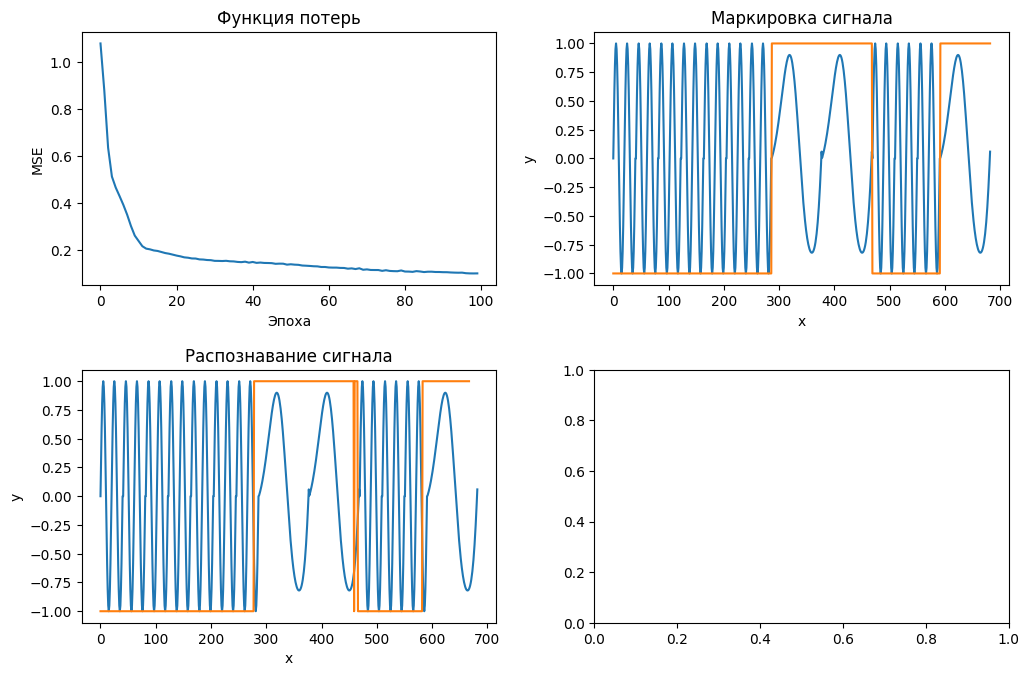

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6.5))
fig.tight_layout(h_pad = 4, w_pad = 4)

axes[0, 0].set_title('Функция потерь')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].plot(train_losses)

axes[0, 1].set_title('Маркировка сигнала')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
axes[0, 1].plot(signal)
axes[0, 1].plot(labels)

axes[1, 0].set_title('Распознавание сигнала')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
axes[1, 0].plot(signal)
axes[1, 0].plot(predicted)